In [44]:
# config.py
epsilon_energy = 5.0
delta_energy = 5.0
lambda_energy = 0.25
alpha_fgsm = 8 / 255

num_classes = 10
batch_size = 16
epochs = 10
lr = 0.005
device = 'cuda'

## CIFAR-10 to PNG images (run once on your machine)

In [10]:
from torchvision.datasets import CIFAR10
from torchvision.utils import save_image
import torchvision.transforms.v2 as transforms
import os

def extract_cifar10_as_images(root='./data'):
    dataset = CIFAR10(root=root, train=True, download=True)
    base_dir = os.path.join(root, "cifar10-images/train")
    os.makedirs(base_dir, exist_ok=True)

    for idx, (img, label) in enumerate(dataset):
        class_dir = os.path.join(base_dir, str(label))
        os.makedirs(class_dir, exist_ok=True)
        save_path = os.path.join(class_dir, f"{idx}.png")
        save_image(transforms.ToTensor()(img), save_path)

    # Repeat for test set
    dataset = CIFAR10(root=root, train=False, download=True)
    base_dir = os.path.join(root, "cifar10-images/test")
    os.makedirs(base_dir, exist_ok=True)

    for idx, (img, label) in enumerate(dataset):
        class_dir = os.path.join(base_dir, str(label))
        os.makedirs(class_dir, exist_ok=True)
        save_path = os.path.join(class_dir, f"{idx}.png")
        save_image(transforms.ToTensor()(img), save_path)

extract_cifar10_as_images()

## `torch` dataset and loader formation

In [45]:
# dataset.py
import torch
from torch.utils.data import Dataset
from torchvision.io import decode_image, ImageReadMode
import os
import glob

from torchvision.transforms import v2
from torchvision.transforms.functional import InterpolationMode

from torch.utils.data import DataLoader
# from config import batch_size


class CIFAR10(Dataset):
    def __init__(self, root, train=True, transform=None):
        split = "train" if train else "test"
        self.samples = []
        base_dir = os.path.join(root, "cifar10-images", split)

        for class_id in range(10):
            class_dir = os.path.join(base_dir, str(class_id))
            for img_path in glob.glob(os.path.join(class_dir, "*.png")):
                self.samples.append((img_path, class_id))

        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = decode_image(path, mode=ImageReadMode.RGB)  # (C, H, W), uint8
        if self.transform:
            img = self.transform(img) # may or may not be in [0, 1], check your transforms
        return img, label


resnet18_preprocess = v2.Compose([
    v2.Resize(224, interpolation=InterpolationMode.BILINEAR),
    # v2.CenterCrop(224),
    v2.ToDtype(torch.float32, scale=True),  # to [0, 1] ! ! !
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])
])


train_dataset = CIFAR10(root='./data', train=True, transform=resnet18_preprocess)
test_dataset = CIFAR10(root='./data', train=False, transform=resnet18_preprocess)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2, pin_memory=True)

## Model definition

In [46]:
# model.py
import torch
import torch.nn as nn
import torchvision.models as models

class ProjHead(nn.Module):
    def __init__(self, in_dim, proj_dim):
        super().__init__()
        self.fc = nn.Linear(in_dim, proj_dim)

    def forward(self, x):
        z_prime = self.fc(x)
        energy = torch.sum(z_prime ** 2, dim=1, keepdim=True)
        return z_prime, energy

class ModelWrapper(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        backbone = models.resnet18(pretrained=True)
        backbone.fc = nn.Identity()
        self.model_backbone = backbone
        self.proj_head = ProjHead(512, 512)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        features = self.model_backbone(x)
        z_prime, energy = self.proj_head(features)
        logits = self.classifier(z_prime)
        return logits, energy

In [47]:
# utils.py
import torch
import torch.nn.functional as F
#from config import alpha_fgsm

def fgsm_attack(model, x, y, loss_fn, alpha):
    x_adv = x.detach().clone().requires_grad_(True)
    logits, _ = model(x_adv)
    loss = loss_fn(logits, y)
    loss.backward()
    x_adv = x_adv + alpha * x_adv.grad.sign()
    x_adv = torch.clamp(x_adv, 0, 1)
    return x_adv.detach()

def compute_loss(model, x, y, loss_fn, epsilon, delta, lambda_energy):
    logits_clean, energy_clean = model(x)
    loss_clean = loss_fn(logits_clean, y)

    x_adv = fgsm_attack(model, x, y, loss_fn, alpha_fgsm)
    logits_adv, energy_adv = model(x_adv)
    loss_adv = loss_fn(logits_adv, y)

    loss_energy = 0
    if lambda_energy != 0:
        loss_energy = lambda_energy * (
            F.relu(energy_clean - epsilon) +
            F.relu(epsilon + delta - energy_adv)
        ).mean()

    total_loss = loss_clean + loss_adv + loss_energy

    metrics = {
        'L_clean': loss_clean.item(),
        'L_adv': loss_adv.item(),
        'L_energy': loss_energy.item(),
        'E_clean': energy_clean.mean().item(),
        'E_adv': energy_adv.mean().item(),
    }

    return total_loss, metrics

def predict_with_rejection(model, x, epsilon):
    logits, energy = model(x)
    preds = torch.argmax(logits, dim=1)
    rejected = energy.squeeze() > epsilon
    preds[rejected] = -1  # -1 means abstain
    return preds

## Model training

In [48]:
# train.py
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F
from torchvision.models import ResNet18_Weights
#from model import ModelWrapper
#from utils import compute_loss
#from config import *

In [49]:
model = ModelWrapper(num_classes).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
loss_fn = F.cross_entropy

for epoch in range(epochs):
    model.train()
    total_metrics = {'L_clean': 0, 'L_adv': 0, 'L_energy': 0, 'E_clean': 0, 'E_adv': 0}
    progress_bar = tqdm(train_loader, total=len(train_loader))
    for x, y in progress_bar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss, metrics = compute_loss(model, x, y, loss_fn, epsilon_energy, delta_energy, lambda_energy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        for k in total_metrics:
            total_metrics[k] += metrics[k]

        progress_bar.set_postfix(metrics)

    print(f"[Epoch {epoch+1}]")
    for k in total_metrics:
        print(f"  {k}: {total_metrics[k] / len(train_loader):.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 3125/3125 [07:53<00:00,  6.60it/s, L_clean=0.658, L_adv=0.896, L_energy=0.05, E_clean=3.19, E_adv=15]


[Epoch 1]
  L_clean: 1.5210
  L_adv: 1.6340
  L_energy: 0.1814
  E_clean: 3.9098
  E_adv: 21.3226


100%|██████████| 3125/3125 [07:51<00:00,  6.62it/s, L_clean=0.501, L_adv=0.84, L_energy=0.00105, E_clean=3.1, E_adv=20.5]


[Epoch 2]
  L_clean: 0.7433
  L_adv: 1.1269
  L_energy: 0.0393
  E_clean: 3.4745
  E_adv: 16.6692


100%|██████████| 3125/3125 [07:52<00:00,  6.62it/s, L_clean=0.4, L_adv=1.05, L_energy=0, E_clean=3.17, E_adv=14.3]


[Epoch 3]
  L_clean: 0.4984
  L_adv: 0.8925
  L_energy: 0.0210
  E_clean: 3.3357
  E_adv: 16.1638


100%|██████████| 3125/3125 [07:51<00:00,  6.63it/s, L_clean=0.706, L_adv=1.58, L_energy=0.0203, E_clean=3.48, E_adv=16.4]


[Epoch 4]
  L_clean: 0.3746
  L_adv: 0.7475
  L_energy: 0.0143
  E_clean: 3.2945
  E_adv: 16.0990


100%|██████████| 3125/3125 [07:51<00:00,  6.63it/s, L_clean=0.138, L_adv=0.398, L_energy=0.0137, E_clean=3.42, E_adv=17.3]


[Epoch 5]
  L_clean: 0.2973
  L_adv: 0.6491
  L_energy: 0.0093
  E_clean: 3.2629
  E_adv: 15.9233


100%|██████████| 3125/3125 [07:51<00:00,  6.63it/s, L_clean=0.281, L_adv=0.506, L_energy=0, E_clean=2.94, E_adv=15.7]


[Epoch 6]
  L_clean: 0.2361
  L_adv: 0.5552
  L_energy: 0.0077
  E_clean: 3.2686
  E_adv: 16.1080


100%|██████████| 3125/3125 [07:50<00:00,  6.64it/s, L_clean=0.419, L_adv=0.521, L_energy=0.000577, E_clean=3.02, E_adv=16.5]


[Epoch 7]
  L_clean: 0.1910
  L_adv: 0.4803
  L_energy: 0.0063
  E_clean: 3.2756
  E_adv: 16.0151


100%|██████████| 3125/3125 [07:51<00:00,  6.62it/s, L_clean=0.0332, L_adv=0.435, L_energy=0.00402, E_clean=3.4, E_adv=14.8]


[Epoch 8]
  L_clean: 0.1585
  L_adv: 0.4205
  L_energy: 0.0055
  E_clean: 3.2771
  E_adv: 16.3163


100%|██████████| 3125/3125 [07:51<00:00,  6.63it/s, L_clean=0.0869, L_adv=0.287, L_energy=0, E_clean=3.31, E_adv=18.7]


[Epoch 9]
  L_clean: 0.1360
  L_adv: 0.3747
  L_energy: 0.0057
  E_clean: 3.2716
  E_adv: 16.5221


100%|██████████| 3125/3125 [07:50<00:00,  6.64it/s, L_clean=0.0589, L_adv=0.5, L_energy=0.0428, E_clean=3.98, E_adv=16.4]

[Epoch 10]
  L_clean: 0.1224
  L_adv: 0.3432
  L_energy: 0.0079
  E_clean: 3.2869
  E_adv: 16.6707


In [55]:
torch.save(model.state_dict(), "model.pt")

## Evaluation

In [ ]:
model = ModelWrapper(num_classes).to(device)
model.load_state_dict(torch.load("model.pt"))

In [56]:
# evaluate.py
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
# from model import ModelWrapper
# from utils import fgsm_attack, predict_with_rejection
# from config import *

def evaluate(model, loader, abstention_threshold, examples=float("inf")):
    model.eval()

    all_clean_E = list()
    all_adv_E = list()

    clean_correct = 0
    clean_total = 0
    clean_rejects = 0
    clean_no_defense_correct = 0

    robust_correct = 0
    robust_total = 0
    robust_rejects = 0
    robust_no_defense_correct = 0

    # with torch.no_grad(): -- prohibited, we need gradients for FGSM attack
    i = -1
    for x, y in tqdm(loader, total=len(loader)):
        i += 1
        if i > examples:
            break
        x, y = x.to(device), y.to(device)

        logits_clean, energy_clean = model(x)
        all_clean_E.append(energy_clean.cpu().detach())
        preds_clean = torch.argmax(logits_clean, dim=1)
        reject_clean = (energy_clean.squeeze() > abstention_threshold)
        valid_clean = ~reject_clean

        clean_correct += (preds_clean[valid_clean] == y[valid_clean]).sum().item()
        clean_no_defense_correct += (preds_clean == y).sum().item()
        clean_rejects += reject_clean.sum().item()
        clean_total += y.size(0)

        x_adv = fgsm_attack(model, x, y, F.cross_entropy, alpha_fgsm)
        logits_adv, energy_adv = model(x_adv)
        all_adv_E.append(energy_adv.cpu().detach())
        preds_adv = torch.argmax(logits_adv, dim=1)
        reject_adv = (energy_adv.squeeze() > abstention_threshold)
        valid_adv = ~reject_adv

        robust_correct += (preds_adv[valid_adv] == y[valid_adv]).sum().item()
        robust_no_defense_correct += (preds_adv == y).sum().item()
        robust_rejects += reject_adv.sum().item()
        robust_total += y.size(0)


    if clean_total == clean_rejects:
        clean_acc = float("NaN")
    else:
        clean_acc = clean_correct / (clean_total - clean_rejects)
    clean_no_def_acc = clean_no_defense_correct / clean_total
    clean_reject_rate = clean_rejects / clean_total

    if robust_total == robust_rejects:
        robust_acc = float("NaN")
    else:
        robust_acc = robust_correct / (robust_total - robust_rejects)
    robust_no_def_acc = robust_no_defense_correct / robust_total
    robust_reject_rate = robust_rejects / robust_total

    print(f"Clean Accuracy (rejected samples excluded): {clean_acc:.4f}")
    print(f"Clean Accuracy (rejected samples included): {clean_no_def_acc:.4f}")
    print(f"Clean Rejection Rate:       {clean_reject_rate:.4f}")
    print(f"Robust Accuracy (rejected samples excluded): {robust_acc:.4f}")
    print(f"Robust Accuracy (rejected samples included): {robust_no_def_acc:.4f}")
    print(f"Adversarial Detection Rate:  {robust_reject_rate:.4f}")

    all_clean_E = torch.cat(all_clean_E).squeeze().numpy()
    all_adv_E = torch.cat(all_adv_E).squeeze().numpy()
    return all_clean_E, all_adv_E

import matplotlib.pyplot as plt
import numpy as np

def energy_hist(energy_clean, energy_adv, abstention_threshold, binwidth=0.5):
    plt.hist(energy_clean, alpha=0.5, label='Clean Energy', bins=np.arange(min(energy_clean), max(energy_clean) + binwidth, binwidth))
    plt.hist(energy_adv, alpha=0.5, label='Adversarial Energy', bins=np.arange(min(energy_clean), max(energy_clean) + binwidth, binwidth))
    plt.axvline(abstention_threshold, color='red', linestyle='--', label='Abstention Threshold')
    plt.xlabel("Energy")
    plt.ylabel("Count")
    plt.title("Energy Distribution: Clean vs Adversarial")
    plt.legend()
    plt.grid(True)
    plt.show()


100%|██████████| 3125/3125 [04:21<00:00, 11.93it/s]


Clean Accuracy (rejected samples excluded): 0.9709
Clean Accuracy (rejected samples included): 0.9711
Clean Rejection Rate:       0.0075
Robust Accuracy (rejected samples excluded): 0.6582
Robust Accuracy (rejected samples included): 0.6585
Adversarial Detection Rate:  0.0009


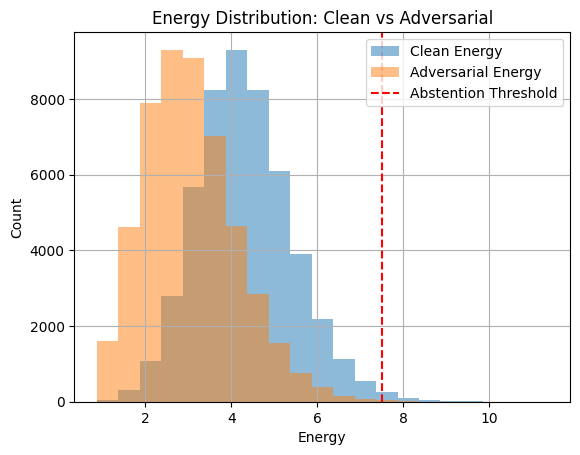

In [57]:
E_clean, E_adv = evaluate(model, train_loader, epsilon_energy+0.5*delta_energy)
energy_hist(E_clean, E_adv, epsilon_energy+0.5*delta_energy)

100%|██████████| 625/625 [00:52<00:00, 11.85it/s]


Clean Accuracy (rejected samples excluded): 0.8618
Clean Accuracy (rejected samples included): 0.8624
Clean Rejection Rate:       0.0047
Robust Accuracy (rejected samples excluded): 0.5394
Robust Accuracy (rejected samples included): 0.5397
Adversarial Detection Rate:  0.0006


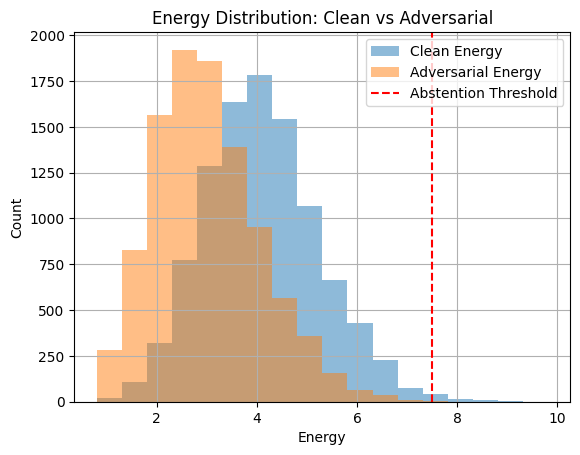

In [58]:
E_clean, E_adv = evaluate(model, test_loader, epsilon_energy+0.5*delta_energy)
energy_hist(E_clean, E_adv, epsilon_energy+0.5*delta_energy)